In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Exploratory data analysis

In [16]:
# load data
stocks = pd.read_csv('data/returns/stock_returns.csv', index_col=0)

In [17]:
stocks.index = pd.to_datetime(stocks.index)

In [18]:
stocks.shape

(2516, 16)

In [19]:
stocks.isna().sum()

AMGN      0
GSK       0
NVO       0
REGN      1
VRTX      2
BIIB      0
GILD      0
ALXN      0
BMY       0
JNJ       0
LLY       0
MRK       0
PFE       0
AZN       0
NVS       0
ABBV    755
dtype: int64

(-0.15, 0.15)

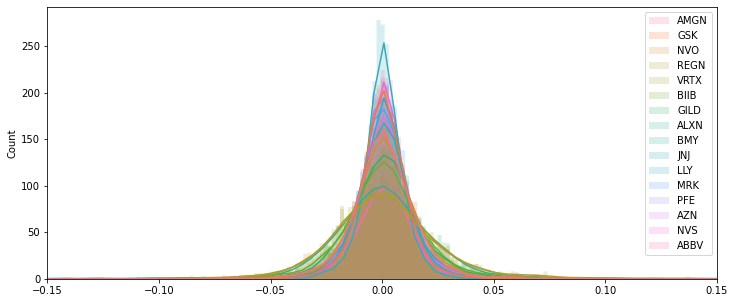

In [20]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(stocks, ax=ax, fill=True, kde=True, bins=500, element="step", linewidth=0.0, alpha=0.2)
ax.set_xlim([-0.15, 0.15])

In [21]:
snp500 = pd.read_csv('data/returns/market_returns.csv', index_col=0)

In [22]:
snp500.index = pd.to_datetime(snp500.index)

In [23]:
snp500.isna().sum()

^GSPC    0
dtype: int64

<AxesSubplot:xlabel='date'>

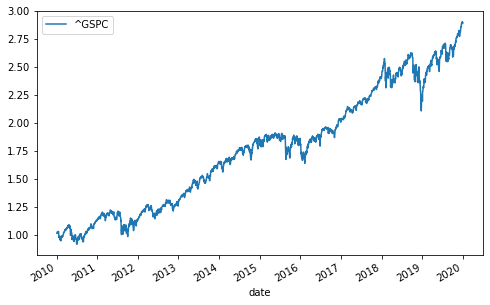

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
(snp500+1).cumprod().plot(ax=ax)

# Data cleaning

In [25]:
stocks[['REGN','VRTX']] = stocks[['REGN','VRTX']].fillna(0)

In [26]:
stocks[['ABBV']].loc['2013-01-03':, :].isna().sum()

ABBV    0
dtype: int64

# Save clean returns

In [27]:
filename = 'data/returns/clean/stock_returns.csv'

if not os.path.exists(filename):
    stocks.to_csv(filename)

In [29]:
filename = 'data/returns/clean/market_returns.csv'

if not os.path.exists(filename):
    snp500.to_csv(filename)